# Hard Voting Classification

This notebook performs classification using a Hard Voting ensemble on Galaxy10 embeddings extracted via a ResNet-101 model pretrained on ImageNet.

We include:
- Evaluation of a large ensemble using hard majority voting
- Accuracy, balanced accuracy, precision, recall, and F1 score
- Confusion matrix and per-class report
- Hierarchical class relation analysis

In hard voting, each model predicts independently, and the final prediction is the class most models agree on.

We use a diverse set of classifiers including:
- Linear models: Ridge, Logistic Regression, SGD, Perceptron, Passive-Aggressive
- Discriminant analysis: LDA, QDA
- Tree-based models: Decision Tree, Random Forest, Extra Trees
- Boosting methods: AdaBoost, Gradient Boosting, XGBoost
- Distance-based: KNN
- Neural nets: MLP
- Probabilistic: GaussianNB
- Bagging ensembles: KNN and Decision Tree base learners
- Baseline: DummyClassifier (most frequent strategy)

Because of the large number of models involved, we use standard hyperparameters to ensure balanced training time and consistency across classifiers.


## Imports

In [91]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# Classifiers used in the final hard voting ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    VotingClassifier
)
from sklearn.linear_model import (
    LogisticRegression,
    Perceptron,
    PassiveAggressiveClassifier,
    SGDClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis
)
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier


## PCA on ResNet101 Embeddings

Applies PCA to reduce the dimensionality of the entire dataset using the precomputed ResNet101 embeddings.


In [92]:
# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# PCA to keep 90% variance (fit only on training data)
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 11
Reduced Validation dimension: 11
Reduced Test dimension: 11


## Hard Voting Ensemble with Diverse Classifiers

This block builds and evaluates a **hard voting ensemble** that combines predictions from a broad set of classical machine learning models. Each model contributes one vote, and the final prediction is made by majority rule. The ensemble includes linear models, tree-based methods, ensemble learners, probabilistic classifiers, and neural networks, offering robustness through diversity.

### Included Classifiers:

- **Ridge Classifier** (`RidgeClassifier`): A linear classifier with L2 regularization, stable in high-dimensional settings.
- **Linear Discriminant Analysis** (`LinearDiscriminantAnalysis`): Projects data to maximize class separability; handles collinearity well.
- **AdaBoost** (`AdaBoostClassifier`): Boosts performance by focusing on misclassified examples through reweighting.
- **K-Nearest Neighbors** (`KNeighborsClassifier`): Classifies based on the majority label of the closest neighbors.
- **Linear Support Vector Machine** (`LinearSVC`): Finds a linear hyperplane that maximizes margin between classes.
- **Decision Tree** (`DecisionTreeClassifier`): Learns decision rules from data via recursive splitting.
- **Random Forest** (`RandomForestClassifier`): Bagged ensemble of decision trees with feature randomness.
- **Extra Trees** (`ExtraTreesClassifier`): Similar to Random Forest but introduces more randomization in splits.
- **Gradient Boosting** (`GradientBoostingClassifier`): Sequentially adds trees that correct previous errors.
- **XGBoost** (`XGBClassifier`): Scalable gradient boosting with regularization and GPU/CPU acceleration.
- **Logistic Regression** (`LogisticRegression`): Linear model that estimates class probabilities using the logistic function.
- **Stochastic Gradient Descent** (`SGDClassifier`): Optimizes a linear model using stochastic gradient descent; here used with log-loss.
- **Passive-Aggressive Classifier** (`PassiveAggressiveClassifier`): Online learning model that updates only on incorrect predictions.
- **Perceptron** (`Perceptron`): A simple binary linear classifier updated using SGD.
- **Gaussian Naive Bayes** (`GaussianNB`): Assumes normally distributed features and conditional independence.
- **Quadratic Discriminant Analysis** (`QuadraticDiscriminantAnalysis`): Models each class with its own covariance matrix.
- **Bagging (Decision Tree)** (`BaggingClassifier` with `DecisionTreeClassifier`): Trains multiple trees on bootstrapped subsets for reduced variance.
- **Bagging (KNN)** (`BaggingClassifier` with `KNeighborsClassifier`): Bagging applied to KNN to increase robustness.
- **Multilayer Perceptron** (`MLPClassifier`): A shallow neural network with one hidden layer of 50 units.
- **Dummy Classifier** (`DummyClassifier`): A naive baseline that always predicts the most frequent class.

This ensemble is trained on PCA-reduced features and evaluated using accuracy, balanced accuracy, precision, recall, and F1-score.


In [93]:
# Define classifiers (sensitive models first + fixed)
classifiers = [
    ('ridge', RidgeClassifier(alpha=1.0, solver='lsqr')),
    ('lda', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=0.5, algorithm='SAMME', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('svm', LinearSVC(C=0.5, max_iter=1000, dual=False, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=50, max_depth=15, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, verbosity=0, use_label_encoder=False, random_state=42)),
    ('logreg', LogisticRegression(C=1.0, max_iter=500, solver='lbfgs', random_state=42)),
    ('sgd', SGDClassifier(loss='log_loss', max_iter=500, tol=1e-3, random_state=42)),
    ('pa', PassiveAggressiveClassifier(max_iter=500, random_state=42)),
    ('perceptron', Perceptron(max_iter=500, random_state=42)),
    ('gnb', GaussianNB()),
    ('qda', QuadraticDiscriminantAnalysis(reg_param=0.1)),
    ('bagging_dt', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=42)),
    ('bagging_knn', BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3), n_estimators=10, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)),
    ('dummy', DummyClassifier(strategy='most_frequent', random_state=42))
]

# Train ensemble
voting_clf = VotingClassifier(estimators=classifiers, voting='hard')
voting_clf.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred = voting_clf.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bal_acc:.4f}")
print(f"Macro Precision:     {precision:.4f}")
print(f"Macro Recall:        {recall:.4f}")
print(f"Macro F1 Score:      {f1:.4f}")


Accuracy:            0.8837
Balanced Accuracy:   0.7527
Macro Precision:     0.7728
Macro Recall:        0.7527
Macro F1 Score:      0.7614


## Confusion Matrices

Displays two confusion matrices: one with raw counts and one with row-wise percentages for the test set predictions.


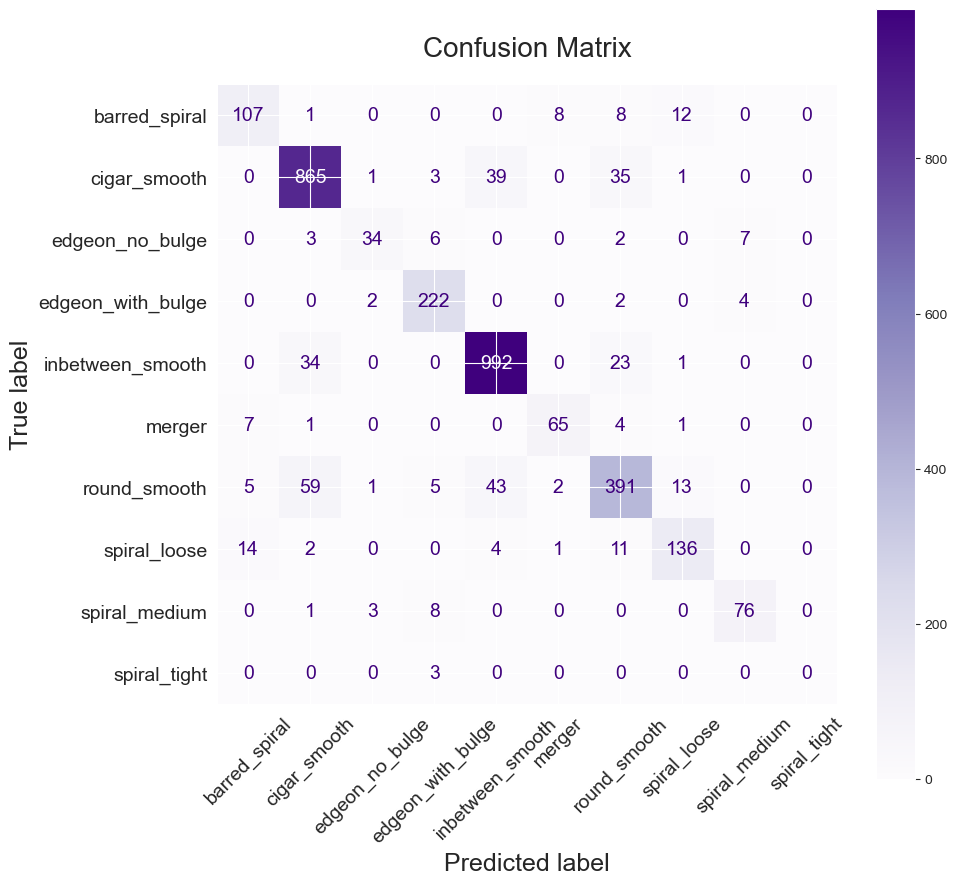

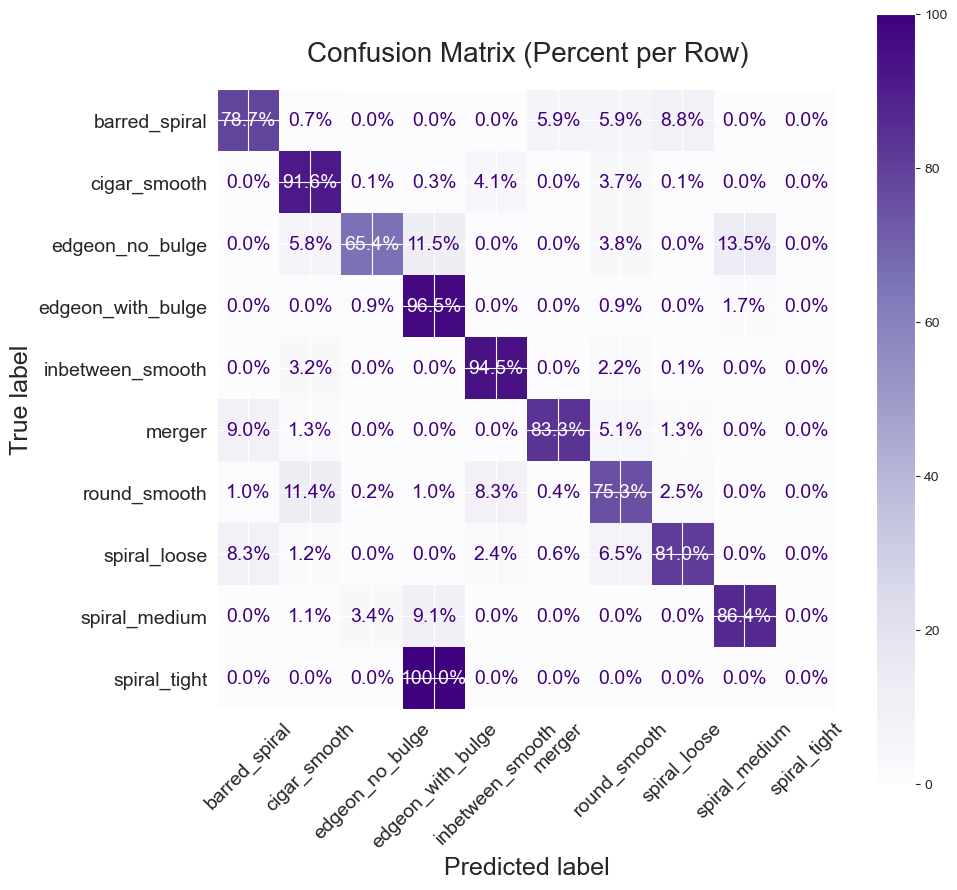

In [94]:
# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Confusion matrix (row-wise percentages)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Classification Report

Prints precision, recall, F1 score, and support for each class in the test set.


In [95]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.8045    0.7868    0.7955       136
     cigar_smooth     0.8954    0.9163    0.9058       944
  edgeon_no_bulge     0.8293    0.6538    0.7312        52
edgeon_with_bulge     0.8988    0.9652    0.9308       230
 inbetween_smooth     0.9202    0.9448    0.9323      1050
           merger     0.8553    0.8333    0.8442        78
     round_smooth     0.8214    0.7534    0.7859       519
     spiral_loose     0.8293    0.8095    0.8193       168
    spiral_medium     0.8736    0.8636    0.8686        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8837      3268
        macro avg     0.7728    0.7527    0.7614      3268
     weighted avg     0.8813    0.8837    0.8819      3268



## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

Skipping class spiral_tight: no predictions in test set.


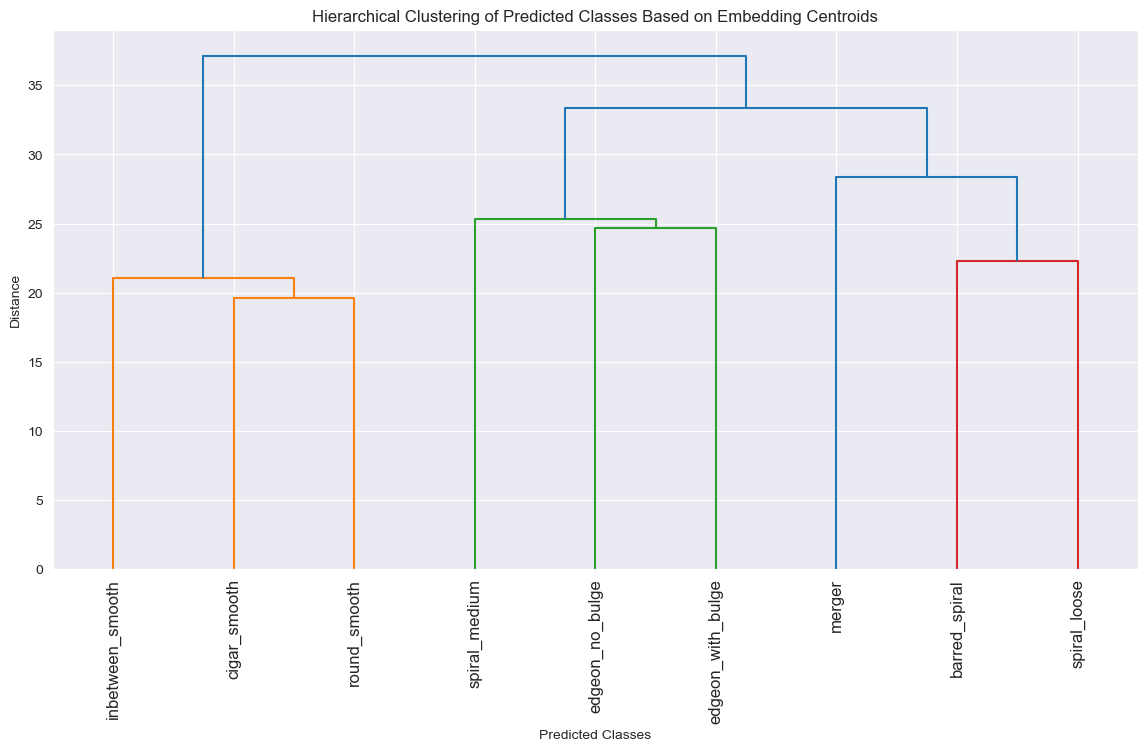

In [96]:
# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()